# Movie Recommendation System Using Collaborative Filtering


- Nama: Nabilla Nurulita Dewi

## Problem Statement

- Pengguna kesulitan menemukan film yang relevan di tengah ribuan pilihan yang tersedia di platform digital, menyebabkan pengalaman pengguna yang tidak optimal.
- Tidak semua pengguna memiliki riwayat interaksi atau preferensi historis, yang membuat pendekatan Collaborative Filtering menjadi kurang efektif (terutama pada kasus cold-start).
- Platform membutuhkan sistem yang dapat memberikan rekomendasi secara otomatis berdasarkan konten film itu sendiri, tanpa bergantung pada data pengguna.

## Data Exploration & Preparation



### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

### Load Dataset

Dataset yang digunakan dalam proyek ini berjudul **"Amazon Electronics Products 10k items - 2023"**, yang diambil dari platform Kaggle:
https://www.kaggle.com/datasets/akeshkumarhp/electronics-products-amazon-10k-items/data berisi 9.600 baris dan 10 kolom.

Kolom:
- Idx
- Name
- Main Category
- Sub Category
- Image
- Link
- Ratings
- Num of Ratings
- Discount Price
- Actual

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/Dicoding/recommender/dataset/movie.zip'
unzip_path = '/content/drive/MyDrive/Dicoding/recommender/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

In [4]:
movies = pd.read_csv('/content/drive/MyDrive/Dicoding/recommender/dataset/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Dicoding/recommender/dataset/ratings.csv')
ratings.drop(columns='timestamp', inplace=True)

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


### Number of rows and columns

In [7]:
# Mengecek jumlah baris dan kolom
print(movies.shape)

(10329, 3)


In [8]:
# Mengecek jumlah baris dan kolom
print(ratings.shape)

(105339, 3)


### Data type of each column

In [9]:
# Mengecek tipe data tiap kolom
print(movies.dtypes)

movieId     int64
title      object
genres     object
dtype: object


In [10]:
# Mengecek tipe data tiap kolom
print(ratings.dtypes)

userId       int64
movieId      int64
rating     float64
dtype: object


### Checking for missing values

In [11]:
# Mengecek nilai yang hilang
print(movies.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


In [12]:
# Mengecek nilai yang hilang
print(ratings.isnull().sum())

userId     0
movieId    0
rating     0
dtype: int64


## Exploratory Data Analysis (EDA)

In [13]:
print("Jumlah rating:", len(ratings))
print("Jumlah user unik:", ratings['userId'].nunique())
print("Jumlah movie unik:", ratings['movieId'].nunique())

Jumlah rating: 105339
Jumlah user unik: 668
Jumlah movie unik: 10325


In [14]:
print(ratings['rating'].describe())


count    105339.000000
mean          3.516850
std           1.044872
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


### Distribusi Rating

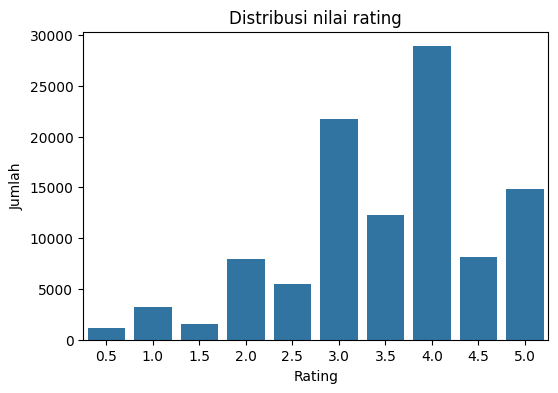

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=ratings)
plt.title("Distribusi nilai rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

### Top 10 Film Paling Sering Dirating

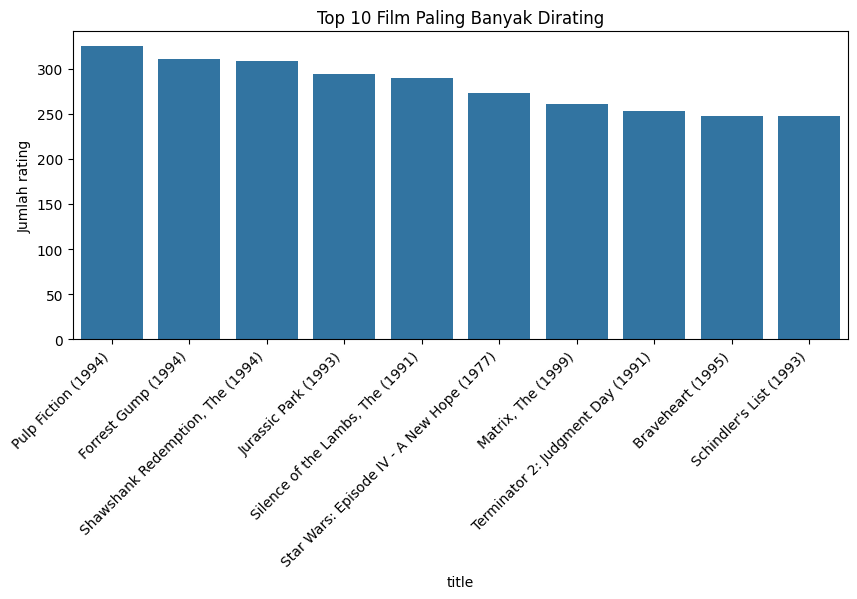

In [17]:
top_movies = ratings['movieId'].value_counts().head(10).index
movie_names = movies[movies['movieId'].isin(top_movies)]

top_movie_counts = ratings[ratings['movieId'].isin(top_movies)]['movieId'].value_counts()

plt.figure(figsize=(10,4))
sns.barplot(x=movie_names.set_index('movieId').loc[top_movies]['title'], y=top_movie_counts.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Jumlah rating")
plt.title("Top 10 Film Paling Banyak Dirating")
plt.show()

### Genre Terpopuler

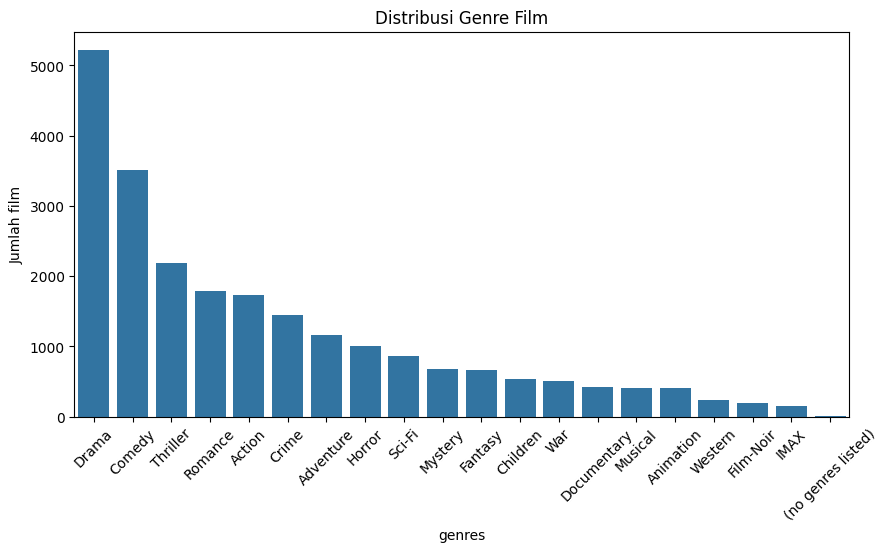

In [18]:
# Pecah genre dan hitung frekuensi
genre_series = movies['genres'].str.split('|').explode()
genre_counts = genre_series.value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45)
plt.ylabel("Jumlah film")
plt.title("Distribusi Genre Film")
plt.show()

### Rating Rata-Rata per User

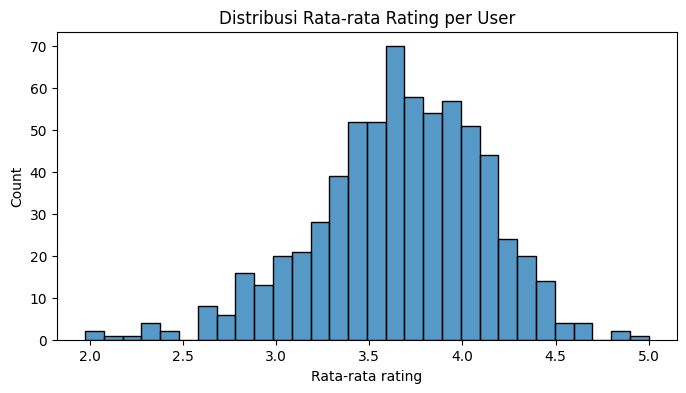

In [20]:
user_avg = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(8,4))
sns.histplot(user_avg, bins=30)
plt.title("Distribusi Rata-rata Rating per User")
plt.xlabel("Rata-rata rating")
plt.show()

Membuat kolom text gabungan dari title dan genres agar bisa diproses sebagai input model embedding berbasis teks.


In [21]:
movies['text'] = movies['title'] + ' ' + movies['genres'].fillna('')

## Embedding

Menggunakan model pre-trained Sentence-BERT (all-MiniLM-L6-v2) untuk mengubah teks film menjadi representasi vektor berdimensi 384.


In [22]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # ringan dan cepat

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [23]:
texts = movies['text'].tolist()
embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

Batches:   0%|          | 0/323 [00:00<?, ?it/s]

In [24]:
# Simpan hasil ke dalam matrix untuk perhitungan cepat
movie_ids = movies['movieId'].tolist()
movie_id_to_index = {mid: i for i, mid in enumerate(movie_ids)}
valid_movie_ids = set(movie_ids)

In [25]:
# Hanya pakai rating >= 4 dan movieId yang ada di embeddings
user_likes = ratings[
    (ratings['rating'] >= 4.0) & (ratings['movieId'].isin(valid_movie_ids))
].groupby('userId')['movieId'].apply(list)

# Hanya pilih user yang punya minimal 6 film disukai
sample_users = user_likes[user_likes.apply(len) >= 6].sample(50, random_state=42)

## Recommendation

Menghitung Cosine Similarity antara semua film berdasarkan embedding, menghasilkan matriks kesamaan antar film. Fungsi untuk memberikan rekomendasi Top-5 film paling mirip berdasarkan film input tertentu (movieId).

In [26]:
def recommend_user_profile(user_movie_ids, top_n=5):
    valid_ids = [mid for mid in user_movie_ids if mid in movie_id_to_index]
    if len(valid_ids) == 0:
        return []

    liked_embeddings = [embeddings[movie_id_to_index[mid]] for mid in valid_ids]
    user_vector = np.mean(liked_embeddings, axis=0).reshape(1, -1)

    sim_scores = cosine_similarity(user_vector, embeddings).flatten()
    sim_indices = sim_scores.argsort()[::-1]

    recommended = []
    for idx in sim_indices:
        candidate_id = movie_ids[idx]
        if candidate_id not in valid_ids:
            recommended.append(candidate_id)
        if len(recommended) >= top_n:
            break

    return recommended  # list of movieId

## Evaluation

Mengelompokkan data rating: mengambil hanya film yang diberi rating ≥3.5 oleh user. User dengan minimal 5 rating diseleksi sebagai sampel uji (50 user) untuk evaluasi sistem.


In [28]:
def precision_at_k(recommended, relevant, k=5):
    if not recommended: return 0.0
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k=5):
    if not relevant: return 0.0
    return len(set(recommended[:k]) & set(relevant)) / len(relevant)

def ndcg_at_k(recommended, relevant, k=5):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / np.log2(i + 2)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0.0

In [29]:
# NEW EVALUATION LOOP
precision_scores, recall_scores, ndcg_scores = [], [], []

for user_id, liked_movie_ids in tqdm(sample_users.items()):
    valid_movies = [mid for mid in liked_movie_ids if mid in movie_id_to_index]
    if len(valid_movies) < 2:
        continue

    hits = 0
    total = 0

    for i, mid in enumerate(valid_movies):
        query = [mid]
        ground_truth = valid_movies[:i] + valid_movies[i+1:]
        recommendations = recommend_user_profile(query, top_n=5)

        if not recommendations:
            continue

        prec = precision_at_k(recommendations, ground_truth)
        rec = recall_at_k(recommendations, ground_truth)
        ndcg = ndcg_at_k(recommendations, ground_truth)

        precision_scores.append(prec)
        recall_scores.append(rec)
        ndcg_scores.append(ndcg)

print(f"\nTotal kasus: {len(precision_scores)}")
print(f"Precision@5: {np.mean(precision_scores):.4f}")
print(f"Recall@5:    {np.mean(recall_scores):.4f}")
print(f"NDCG@5:      {np.mean(ndcg_scores):.4f}")


50it [00:57,  1.16s/it]


Total kasus: 4096
Precision@5: 0.0833
Recall@5:    0.0032
NDCG@5:      0.0905


## Conclusion

Proyek ini berhasil membangun sistem rekomendasi film menggunakan pendekatan Content-Based Filtering dengan Sentence-BERT. Dengan memanfaatkan representasi semantik dari judul dan genre film, sistem mampu memberikan rekomendasi berdasarkan kemiripan konten. Evaluasi menggunakan Precision@5, Recall@5, dan NDCG@5 menunjukkan bahwa meskipun model belum sangat akurat, pendekatan ini relevan untuk cold-start problem dan bisa menjadi fondasi sistem rekomendasi hybrid di masa depan.
